# Keras Neural Network implementation

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_validate
from tensorflow import keras
from tensorflow.keras import layers, metrics, callbacks
from keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend as K
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Project files

In [17]:
sys.path.append('./drive/MyDrive/TFG/implementations/machine_learning_tfg/')
from src.utils.model_metrics_generator import ModelMetricsGenerator 
from src.utils.cross_validation_utils import CrossValidationMetricsResultPrinter
from src.utils.my_metrics import accuracy_precision_recall_specifity_f2_score

# Data loading

In [18]:
#input_data = pd.read_excel('/content/drive/MyDrive/TFG/notebooks/data/prepared/prepared_ICU_Prediction.xlsx')
input_data = pd.read_excel('/content/drive/MyDrive/TFG/implementations/machine_learning_tfg/data/prepared/prepared_ICU_Prediction.xlsx')
ground_truth = input_data['ICU']
sample_data = input_data.drop('ICU', axis=1)
train_data, test_data, train_truth, test_truth = train_test_split(sample_data, ground_truth, test_size=0.2, shuffle=True)
num_features = train_data.shape[1]

# Functions

In [23]:
def specificity(y_true, y_pred):    
  """ Function that implements specificity metric, its author is https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd

  """
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())


def create_neural_network(layers, optimizer='adam', loss_function='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision', specificity]):
  """ Create a Keras neural network with the folloging attributes

  Arguments:
    layers: List of layers that will have the NN.Ensure  you pass them in the right oreder e.g: [first layer, ..., n hidden layers,..., lastlayer] 
          becuase they will be added in the same order.
  
    The other arguments are autoexplicatives.

  Returns:
    A Keras neural network model

  """
  model = keras.Sequential()
  for layer in layers:
    model.add(layer)

  model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
    )
  
  return model



def fit_neural_network(model, train_data, train_truth, batch_size, epochs):
  """ Fit a keras NN with teh given arguments
  
  Returns: A Keras history object.
  """

  early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
  )
  
  history = model.fit(
    train_data, train_truth,
    validation_data=(test_data, test_truth),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose = 0
    )
  
  return history


## Metrics functions

In [27]:
def get_accuracy(history):
  accuracy =  history['val_accuracy'].iloc[-1] *100
  return accuracy

def get_recall(history):
  recall =  history['val_recall'].iloc[-1] *100
  return recall

def get_precision(history):
  precision =  history['val_precision'].iloc[-1] *100
  return precision

def get_specificity(history):
  specificity =  history['val_specificity'].iloc[-1] *100
  return specificity

def get_fbeta_measure(history, beta):
  row = history.iloc[-1]
  precision = row.val_precision
  recall = row.val_recall
  fbeta_score = (1+beta**2)*((precision * recall)/((beta**2 *precision)+recall)) *100
  return fbeta_score

### Show Metrics values


In [31]:
def show_results(history):
  plot_neural_network_loss(history)
  print_neural_network_metrics(history)

def plot_neural_network_loss(history):
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.title('Comportamiento de la función de pérdida')
    plt.ylabel('Valor')
    plt.xlabel('Epochs')
    plt.legend(title='', labels=['Entrenamiento', 'Validacion'])

def print_neural_network_metrics(history):
  history_df = pd.DataFrame(history.history)

  accuracy = get_accuracy(history_df)
  print(f'Accuracy: {round(accuracy, 2)}%')

  precision = get_precision(history_df)
  print(f'Precision: {round(precision, 2)}%')

  recall = get_recall(history_df)
  print(f'Recall: {round(recall, 2)}%')

  specificity = get_specificity(history_df)
  print(f'Specifity: {round(specificity, 2)}%')

  f2_score = get_fbeta_measure(history_df, 2)
  print(f'F2-score: {round(f2_score, 2)}%')


## First approach to Keras Neural Network Models


CPU times: user 2.64 s, sys: 38.9 ms, total: 2.67 s
Wall time: 2.59 s
Accuracy: 80.0%
Precision: 82.0%
Recall: 47.13%
Specifity: 96.59%
F2-score: 51.51%


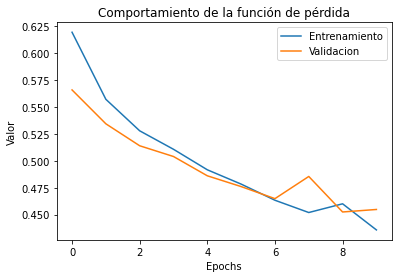

In [38]:
#define hidden layers
neural_network_layers = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model = create_neural_network(layers=neural_network_layers)
%time history = fit_neural_network(model, train_data=train_data, train_truth=train_truth, batch_size=128, epochs=10)

show_results(history)

CPU times: user 2.83 s, sys: 39.1 ms, total: 2.87 s
Wall time: 2.8 s
Accuracy: 76.0%
Precision: 70.59%
Recall: 41.38%
Specifity: 94.32%
F2-score: 45.11%


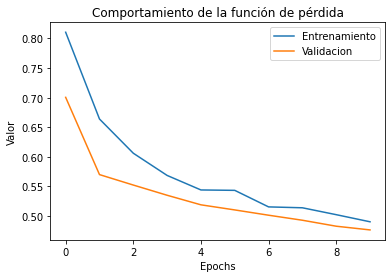

In [39]:
neural_network_layers2 = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),  
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model2 = create_neural_network(layers=neural_network_layers2)
%time history2 = fit_neural_network(model2, train_data=train_data, train_truth=train_truth, batch_size=128, epochs=10)

show_results(history2)

CPU times: user 2.88 s, sys: 49.3 ms, total: 2.93 s
Wall time: 2.84 s
Accuracy: 80.0%
Precision: 70.51%
Recall: 63.22%
Specifity: 88.89%
F2-score: 64.55%


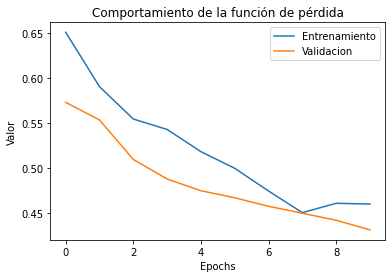

In [40]:
neural_network_layers3 = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=64, activation='relu'),
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]
        
model3 = create_neural_network(layers=neural_network_layers3)
%time history3 = fit_neural_network(model3, train_data=train_data, train_truth=train_truth, batch_size=128, epochs=10)

show_results(history3)

CPU times: user 2.83 s, sys: 57.2 ms, total: 2.89 s
Wall time: 2.78 s
Accuracy: 78.18%
Precision: 84.62%
Recall: 37.93%
Specifity: 97.73%
F2-score: 42.64%


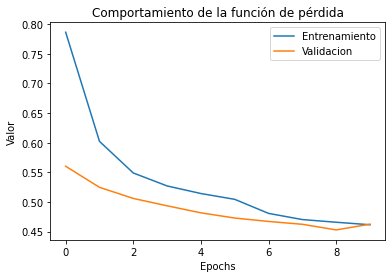

In [47]:
neural_network_layers4 = [
                         layers.Dense(units=128, activation='relu', input_dim=num_features),  
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model4 = create_neural_network(layers=neural_network_layers4)
%time history4 = fit_neural_network(model4, train_data=train_data, train_truth=train_truth, batch_size=128, epochs=10)

show_results(history4)


# Grid search for hyperparameters optimization

@see https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def print_best_grid_search_result(grid_result):
  print(f'El mejore resultado :{grid_result.best_score_} se consigue con {grid_result.best_params_}')

In [ ]:
grid_search_data = input_data.sample(frac=0.3)
grid_search_data_truth = grid_search_data['ICU']
grid_search_data_train = grid_search_data.drop('ICU', axis=1)

## Searching epochs and batch_size

In [ ]:
#Builder function to pass it to KerasClassifier wrapper
def grid_model():
  neural_network_layers = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),  
                         layers.Dense(units=1, activation='sigmoid')
                         ]
  model = create_neural_network(layers=neural_network_layers)
  return model

#hyperparameters values that will be tested during the grid search
batch_size = [8, 16, 32, 64, 128, 256, 512]
epochs = [1, 2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid_model = KerasClassifier(build_fn=grid_model, verbose=0)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(grid_search_data_train, grid_search_data_truth)

print_best_grid_search_result(grid_result)

El mejore resultado :0.7937868038813273 se consigue con {'batch_size': 32, 'epochs': 512}


## Serching number of neurons in hidden layers

In [ ]:
def grid_model_neurons(neurons=1):
  neural_network_layers = [
                         layers.Dense(units=neurons, activation='relu', input_dim=num_features),  
                         layers.Dense(units=1, activation='sigmoid')
                         ]
  model = create_neural_network(layers=neural_network_layers)
  return model

neurons = [1, 2, 4, 8, 16, 32, 64, 128, 256]
param_grid = dict(neurons=neurons)

model_for_neurons = KerasClassifier(build_fn=grid_model_neurons, verbose=0)
grid = GridSearchCV(estimator=model_for_neurons, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(grid_search_data_train, grid_search_data_truth)

print_grid_search_results(grid_result)

El mejore resultado :0.7232624689737955 se consigue con {'neurons': 256}


## Grid search with all required hyperparameters

In [ ]:
def full_grid_search_model(neurons=1, layers_number=1, activation='relu', dropout=0.0, optimizer='adam'):
  
  model = keras.Sequential([layers.Dense(units=neurons, activation='relu', input_dim=num_features)])
  for i in range(layers_number):
    model.add(layers.Dense(units=neurons, activation='relu', input_dim=num_features))
    model.add(layers.Dropout(0.3))
  model.add(layers.Dense(units=1, activation='sigmoid'))

  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall']
    )
  return model

full_grid_model = KerasClassifier(build_fn=full_grid_search_model, verbose=0)

neurons = [1, 2, 4, 8, 16, 32, 64, 128, 256]
layers_number = [1, 2, 3, 4, 5]
#activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid']
#dropout = [0.0, 0.2, 0.3, 0.5, 0.7, 0.9]
#optimizer = [ 'adam', 'sdg', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
batch_size = [8, 16, 32, 64, 128, 256, 512]
epochs = [1, 2, 4, 8, 16, 32, 64, 128, 256, 384, 512]
param_grid = dict(neurons=neurons,layers_number=layers_number, batch_size=batch_size, epochs=epochs)

In [ ]:
grid = GridSearchCV(estimator=full_grid_model, param_grid=param_grid, n_jobs=-1, cv=3)
init_time = time.time()
grid_result = grid.fit(grid_search_data_train, grid_search_data_truth)
minutes_elapsed = (time.time() - init_time) / 60 
#results
print_grid_search_results(grid_result)
print(f'Required minutes to perform an almost full grid search: {minutes_elapsed}')

El mejore resultado :0.8228604594866434 se consigue con {'batch_size': 512, 'epochs': 384, 'layers_number': 4, 'neurons': 128}
Required minutes to perform an almost full grid search: 542.4248905261358


Values obtained with grid search:

* Batch size: 512
* Epochs: 384
* Layers: 4
* Neurons: 128
* Tiempo necesario: 9 horas

**It's a really expensive operation**



# Cross validation

Test the best results obtained with grid search  for hyperparameters applying cross validation using 3 and 10 splits.



In [ ]:
def create_cv_model():
  cv_layers = [
              layers.Dense(units=128, activation='relu', input_dim=num_features),
              layers.Dropout(rate=0.3),
              layers.Dense(units=128, activation='relu'),
              layers.Dropout(rate=0.3),
              layers.Dense(units=128, activation='relu'),
              layers.Dropout(rate=0.3),
              layers.Dense(units=128, activation='relu'),
              layers.Dropout(rate=0.3),
              layers.Dense(units=128, activation='relu'),
              layers.Dropout(rate=0.3),
              layers.Dense(units=1, activation='sigmoid')
              ]
  model = create_neural_network(cv_layers)
  return model

cv_estimator = KerasClassifier(build_fn=create_cv_model, epochs=384, batch_size=512, verbose=0)
metrics = accuracy_precision_recall_specifity_f2_score()

In [ ]:
cv_results = cross_validate(cv_estimator, sample_data , ground_truth , cv=3, scoring = metrics)

printer = CrossValidationMetricsResultPrinter()
printer.print_metrics_report(cv_results)
printer.print_metrics_values(cv_results)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses


Valores medios:
	Fit time: 11.775s.
	Test time: 0.2178s
	Accuracy: 76.38%.
	Precision: 62.2%.
	Recall: 69.41%.
	Specificity: 79.48%.
	F2 score: 67.79%.


11.775
0.2178
76.38
62.2
69.41
79.48
67.79


In [ ]:
cv_results = cross_validate(cv_estimator, sample_data , ground_truth , cv=10, scoring = metrics)

printer = CrossValidationMetricsResultPrinter()
printer.print_metrics_report(cv_results)
printer.print_metrics_values(cv_results)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses


Valores medios:
	Fit time: 15.655s.
	Test time: 0.2107s
	Accuracy: 77.99%.
	Precision: 67.0%.
	Recall: 66.64%.
	Specificity: 83.85%.
	F2 score: 66.24%.


15.655
0.2107
77.99
67.0
66.64
83.85
66.24
